# The mathematical building blocks of neural networks

* CPU/GPU/TPU detection
* Saving and loading checkpoints and models
* https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb#scrollTo=9rGfFwE9XVwz
* https://www.tensorflow.org/tutorials/keras/save_and_load

#### Use for confusion matrix:
* https://gist.github.com/ryoen/21a27720093bb3e82de213f6408faab5

For training and saving checkpoints (weights, models) in Colab TPU mode, the easiest way for persistent storage is:

1. Mount your Google drive
2. Save model checkpoints (weights, models) there

In [1]:
def HR():
    print('-' * 70)

    
def detect_tf_version():
    import tensorflow as tf
    return(f"Tensorflow version: {tf.__version__}")


def detect_memory():
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    if ram_gb < 20:
        ram_level = "(not using high-RAM runtime)"
    else:
        ram_level = "(using high-RAM runtime)"
    return 'Runtime: {:.1f} gigabytes of available RAM {}.'.format(ram_gb, ram_level)


def detect_platform():
    import tensorflow as tf
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        strategy = tf.distribute.TPUStrategy(tpu)
        return (strategy, 'TPU')
    except ValueError:
        physical_devices = tf.config.list_physical_devices('GPU')
        if len(physical_devices) > 0:
            strategy = tf.distribute.MirroredStrategy()
            return (strategy, 'GPU')
        else:
            strategy = tf.distribute.get_strategy()
            return (strategy, 'CPU')

        
def set_mixed_precision(mode):
    from tensorflow import keras
    if mode == 'GPU':
        keras.mixed_precision.set_global_policy("mixed_float16")

        
def get_input_shape():
    # this is the 'source of truth' for input shape
    # This is 784 because we use a Dense layer in the model, with appropriate 1D tensor
    return 784
        
    
def get_data(version="full"):
    from tensorflow.keras.datasets import mnist

    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    # This script is mainly to explore how to save and load weights, 
    # We use the MNIST dataset, but to speed up these runs, we can 
    # use only the first 1000 examples as the default

    from sklearn.utils import shuffle
    train_images, train_labels = shuffle(train_images, train_labels)
    
    
    val_percentage = 0.2
    
    if version == "full":
        # LONG DATASET
        TOTAL_TRAIN = len(train_images) # 60_000
        VAL_LENGTH = int(TOTAL_TRAIN * val_percentage) # 12_000
        TRAIN_MAX_LENGTH = TOTAL_TRAIN - VAL_LENGTH # 48_000
        TEST_MAX_LENGTH = len(test_images) # 10_000
    else:
        # SHORT DATASET
        TOTAL_TRAIN = 2_000
        VAL_LENGTH = int(TOTAL_TRAIN * val_percentage) # 400
        TRAIN_MAX_LENGTH = TOTAL_TRAIN - VAL_LENGTH # 1_600
        TEST_MAX_LENGTH = 1_000

    
    
    print("TOTAL_TRAIN", TOTAL_TRAIN)
    print("VAL_LENGTH", VAL_LENGTH)
    print("TEST_MAX_LENGTH", TEST_MAX_LENGTH)
    HR()
    
    # IMPORTANT - ALWAYS KNOW THE SHAPE YOUR DATA IS IN, AND NEEDS TO BE
    # Preprocess the data by reshaping it into the shape the model expects.
    # From looking at our Model, the first line is
    # layers.Dense(512, activation="relu"),
    # which impies our data needs to be the flattened shape 512, which is 28*28

    train_images = train_images[VAL_LENGTH:TRAIN_MAX_LENGTH]
    val_images = train_images[:VAL_LENGTH]
    test_images = test_images[:TEST_MAX_LENGTH]
    
    train_labels = train_labels[VAL_LENGTH:TRAIN_MAX_LENGTH]
    val_labels = train_labels[:VAL_LENGTH]
    test_labels = test_labels[:TEST_MAX_LENGTH]

    # Transform data to correspond to shape needed for model layer.
    # If we use the full dataset, the original shape of train_images 
    # is (60000, 28, 28), otherwise (1000, 28, 28).
    # After this reshaping for the model, it becomes (1000, 784)
    train_images = train_images.reshape(-1, get_input_shape()) / 255.0
    val_images = val_images.reshape(-1, get_input_shape()) / 255.0
    test_images = test_images.reshape(-1, get_input_shape()) / 255.0

    return (train_images, train_labels, test_images, test_labels, val_images, val_labels)


def create_external_volume(path):
    from google.colab import drive
    try:
        drive.mount(path)
        print(f"External Directory {path} created successfully.")
    except OSError as e:
            print(f"Error: {path} : {e.strerror}")

            
def delete_storage(path):
    import os
    import shutil
    if os.path.exists(path):
        try:
            shutil.rmtree(path)
        except OSError as e:
            print(f"Error: {path} : {e.strerror}")

            
def create_local_volume(path):
    import os
    delete_storage(path)
    try:
        os.makedirs(path, exist_ok = True)
        print(f"Local Directory {path} created successfully.")
    except OSError as error:
        print(f"Local Directory {path} can not be created.")


def get_storage_pathways(platform):
    if platform == 'TPU':
        checkpoint_path = '/content/gdrive/MyDrive/weights/weights.keras'
        model_path = '/content/gdrive/MyDrive/models/model.hdf5'
    else:
        checkpoint_path = './storage/weights/weights.keras'
        model_path = './storage/model/model.hdf5'
    return checkpoint_path, model_path


def create_storage(platform):
    checkpoint_path, model_path = get_storage_pathways(platform)
    if platform == 'TPU':
        create_external_volume('/content/gdrive')
    else:
        create_local_volume('./storage/weights/')
        create_local_volume('./storage/model/')
    return checkpoint_path, model_path


def make_model(steps):
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    # create the model
    model = keras.Sequential([
        layers.Dense(512, activation="relu", input_shape=(get_input_shape(),)),
        layers.Dropout(0.2),
        layers.Dense(10, activation="softmax")
    ])
    # config the model with losses and metrics
    model.compile(
        optimizer='adam', # "rmsprop"
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
        steps_per_execution=steps,
    )
    return model

In [2]:
def create_prediction_idx():
    import matplotlib.pyplot as plt
    from random import randrange
    import random
    import numpy as np

    train_images, train_labels, test_images, test_labels, val_images, val_labels = get_data()
    print("Type of train_images:", type(train_images))
    print(f"train_images.shape: \t{train_images.shape}")
    print(f"train_labels.shape: \t{train_labels.shape}")
    print(f"test_images.shape: \t{test_images.shape}")
    print(f"test_labels.shape: \t{test_labels.shape}")
    HR()

    # parameter size really refers to output-shape, but we just use to indicate 
    # number of items, by using the shape of a 1D list
    num_items = 5
    idx = np.random.choice(test_images.shape[0], size=num_items, replace=False) 
    
    fig = plt.figure(figsize=(9,1.5))
    #fig.subplots_adjust(hspace=0.5, wspace=0.5)
    for i in range(1, num_items+1):
        ax = fig.add_subplot(1, num_items+1, i)
        ax.set_title(test_labels[idx[i-1]])
        ax.set_aspect('equal')
        ax.axis('off')
        ax.imshow(test_images[idx[i-1], :].reshape(28,28))

    return idx

# idx = create_prediction_idx()
# import numpy as np
# for x in np.nditer(idx):
#     print(x)

In [3]:
def get_image():
    from tensorflow.keras.preprocessing.image import img_to_array
    from tensorflow.keras.preprocessing.image import load_img
    import matplotlib.pyplot as plt
    import os
        
    image_pathway = './images/digit.png'
    
    
    if not os.path.exists('./images'):
        os.makedirs('./images')
    
    
    # 3, 8, 9
    try:
        !wget -O {image_pathway} 'https://www.angelsnumbers.com/wp-content/uploads/2019/03/9.jpg'
        #!wget -O {image_pathway} "https://raw.githubusercontent.com/gbih/train/main/test/8.png"
    except ValueError:
        print("Error in downloading image")
        
    #!wget -O image_pathway "https://machinelearningmastery.com/wp-content/uploads/2019/02/sample_image.png"
    #!wget -O ./images/sample_image.jpg "https://www.angelsnumbers.com/wp-content/uploads/2019/03/9.jpg"
    
    # load image 
    img = load_img(image_pathway, color_mode = "grayscale", target_size=(28, 28))
    
    # show image
    plt.imshow(img)
    plt.axis('off')
    
    # convert to numpy array
    x = img_to_array(img)
    
    # reshape into a single sample with 1 channel
    x = x.reshape(1, 28*28)
    #print("SHAPE OF SINGLE IMAGE:", x.shape)
    
    # prepare pixel data
    x = x.astype('float32')
    x = x / 255.0
    
    return x


def single_digit_predict(single_digit, model):
    import numpy as np
    # print(single_digit.shape)
    digit = np.argmax(model.predict(single_digit), axis=-1)
    #print(f"Prediction for single digit image: {digit[0]}")
    return digit[0]


In [4]:
#!wget 'https://www.angelsnumbers.com/wp-content/uploads/2019/03/9.jpg'

Tensorflow version: 2.6.0
Runtime: 8.6 gigabytes of available RAM (not using high-RAM runtime).
Input shape is 784
strategy: <tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x11030b040>
Number of devices: 1
mode: CPU
----------------------------------------------------------------------
Local Directory ./storage/weights/ created successfully.
Local Directory ./storage/model/ created successfully.
TOTAL_TRAIN 60000
VAL_LENGTH 12000
TEST_MAX_LENGTH 10000
----------------------------------------------------------------------
----------------------------------------------------------------------
Type of train_images: <class 'numpy.ndarray'>
train_images.shape: 	(36000, 784)
train_labels.shape: 	(36000,)

test_images.shape: 	(10000, 784)
test_labels.shape: 	(10000,)

val_images.shape: 	(12000, 784)
val_labels.shape: 	(12000,)
----------------------------------------------------------------------


2022-03-26 08:37:44.760711: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-26 08:37:47.711529: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)



Epoch 00001: saving model to ./storage/weights/weights.keras

Epoch 00002: saving model to ./storage/weights/weights.keras

Epoch 00003: saving model to ./storage/weights/weights.keras

Epoch 00004: saving model to ./storage/weights/weights.keras

Epoch 00005: saving model to ./storage/weights/weights.keras

Epoch 00006: saving model to ./storage/weights/weights.keras

Epoch 00007: saving model to ./storage/weights/weights.keras

Epoch 00008: saving model to ./storage/weights/weights.keras

Epoch 00009: saving model to ./storage/weights/weights.keras

Epoch 00010: saving model to ./storage/weights/weights.keras
----------------------------------------------------------------------
EPOCHS: 10
----------------------------------------------------------------------
keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
----------------------------------------------------------------------
INSIDE LEARNING CURVE:
epochs: 10
10
hist.history['loss']: [0.34858039021492004, 0.1559320

/var/folders/vb/glk9sq0x22qbdp2r6prn8h600000gn/T/ipykernel_1286/1680206533.py:122: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(hist.history['val_loss'], "b--", color='orange', label='validate')
/var/folders/vb/glk9sq0x22qbdp2r6prn8h600000gn/T/ipykernel_1286/1680206533.py:130: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(hist.history['val_accuracy'], "b--", color='orange', label='validate')


Predictions on dataset of 10 length:
Predictions : Labels
7 : 7
2 : 2
1 : 1
0 : 0
4 : 4
1 : 1
4 : 4
9 : 9
5 : 5
9 : 9
----------------------------------------------------------------------
TOTAL_TRAIN 60000
VAL_LENGTH 12000
TEST_MAX_LENGTH 10000
----------------------------------------------------------------------
Type of train_images: <class 'numpy.ndarray'>
train_images.shape: 	(36000, 784)
train_labels.shape: 	(36000,)
test_images.shape: 	(10000, 784)
test_labels.shape: 	(10000,)
----------------------------------------------------------------------
Predictions (random selection from test images:
Predictions : Labels
4 : 4
6 : 6
2 : 2
7 : 7
2 : 2
----------------------------------------------------------------------
--2022-03-26 08:38:07--  https://www.angelsnumbers.com/wp-content/uploads/2019/03/9.jpg
Resolving www.angelsnumbers.com (www.angelsnumbers.com)... 172.66.43.194, 172.66.40.62
Connecting to www.angelsnumbers.com (www.angelsnumbers.com)|172.66.43.194|:443... connected.
HT

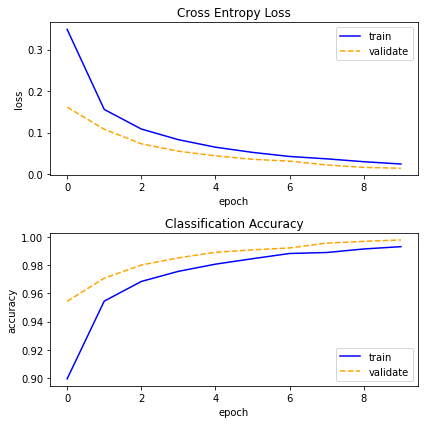

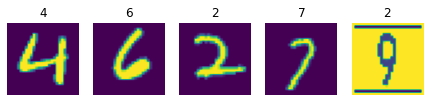

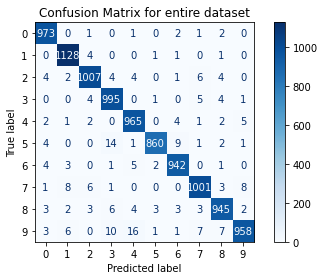

In [5]:
def listing01_save_weights():
    import tensorflow as tf
    import matplotlib.pyplot as plt
    import numpy as np
    import sklearn.metrics
    #from tensorflow import keras
    #from tensorflow.keras import layers
    #import shutil
    
    ##########
    
    print(detect_tf_version())
    print(detect_memory())
    print(f"Input shape is {get_input_shape()}")
    
    strategy, mode = detect_platform()
    print(f"strategy: {strategy}")
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    print(f"mode: {mode}")
    HR()
    
    # only really pertinent when training models
    set_mixed_precision(mode)

    if mode == 'TPU':
        #num_units = 64
        num_epochs = 30 # 20
        steps_per_execution = num_epochs
        batch_size = 32 # IMPORTANT - must be divisible by 8
    elif mode == 'GPU':
        #num_units = 32
        num_epochs = 20
        steps_per_execution = num_epochs
        batch_size = 64
    else:
        #num_units = 12
        num_epochs = 10
        steps_per_execution = 1
        batch_size = 128
    
    checkpoint_path, model_path = create_storage(mode)

    ##########
        
    train_images, train_labels, test_images, test_labels, val_images, val_labels = get_data()
    
    HR()
    print("Type of train_images:", type(train_images))
    print(f"train_images.shape: \t{train_images.shape}")
    print(f"train_labels.shape: \t{train_labels.shape}")
    print()
    print(f"test_images.shape: \t{test_images.shape}")
    print(f"test_labels.shape: \t{test_labels.shape}")
    print()
    print(f"val_images.shape: \t{val_images.shape}")
    print(f"val_labels.shape: \t{val_labels.shape}")
    HR()
    

    # Create and compile the Keras model in the context of strategy.scope.
    with strategy.scope():
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='accuracy',
                patience=2 # Interrupts training when accuracy has stopped improving for more than two epoch
            ),
            tf.keras.callbacks.ModelCheckpoint(
                filepath = checkpoint_path,
                monitor='accuracy', # model.compile metric, as listed in hist.history.keys()
                verbose=1,
                save_weights_only=True,
            )
        ]
        model = make_model(steps_per_execution)

        
    # Outside of strategy scope
    hist = model.fit(
        train_images, 
        train_labels, 
        epochs=num_epochs, 
        batch_size=batch_size,
        callbacks=callbacks,
        validation_data=(val_images, val_labels),
        verbose=0
    )
    HR()

    
    print(f"EPOCHS: {num_epochs}")
    HR()
    print(f"keys: {hist.history.keys()}")
    HR()
    # dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
        
        
        
        
        
        
        
        
        
        
    ### PROBLEM HERE
        
    def learning_curve(hist, epochs):
        print("INSIDE LEARNING CURVE:")
        print(f"epochs: {epochs}")
        print(len(hist.history['loss']))
        print(f"hist.history['loss']: {hist.history['loss']}")
        print(f"hist.history['val_loss']: {hist.history['val_loss']}")
        
    
        fig = plt.figure(figsize=(6,6))
        
        ax1 = fig.add_subplot(211)
        ax1.set_title('Cross Entropy Loss')
#         ax1.plot(epochs, hist.history['loss'], color='blue', label='train')
#         ax1.plot(epochs, hist.history['val_loss'], "b--", color='orange', label='validate')
        ax1.plot(hist.history['loss'], color='blue', label='train')
        ax1.plot(hist.history['val_loss'], "b--", color='orange', label='validate')
        ax1.set_ylabel('loss')
        ax1.set_xlabel('epoch')
        ax1.legend()
        
        ax2 = fig.add_subplot(212)
        ax2.set_title('Classification Accuracy')
        ax2.plot(hist.history['accuracy'], color='blue', label='train')
        ax2.plot(hist.history['val_accuracy'], "b--", color='orange', label='validate')
        ax2.set_ylabel('accuracy')
        ax2.set_xlabel('epoch')
        ax2.legend()
        
        plt.tight_layout()
    
    
    # GB turn off for now
    learning_curve(hist, num_epochs)


        
        

    # Make predictions
    # Since our data in the shape (512,), using test_images[0:10] results in 
    # 10 predictions for 10 digits
    test_digits = test_images[0:10]    
    predictions = model.predict(test_digits)
    print(f"Predictions on dataset of {len(test_digits)} length:")
    print("Predictions : Labels")
    for x in range(len(test_digits)):
        print(f"{predictions[x].argmax()} : {test_labels[x]}")

    HR()

    # Using a randomized selection of test images
    idx = create_prediction_idx()  
    print("Predictions (random selection from test images:")
    print("Predictions : Labels")
    for x in np.nditer(idx):
        #print(test_images[x, :].shape)
        img = test_images[x, :].reshape(1, 784)
        #print(img.shape)
        single_prediction = (single_digit_predict(img, model))
        #print(f"Prediction for random digit image: {single_prediction}")
        #print(f"Label: {test_labels[x]}")
        print(f"{single_prediction} : {test_labels[x]}")

    HR()
    
        
    single_digit = get_image()
    single_prediction = (single_digit_predict(single_digit, model))
    print(f"Prediction for single digit image: {single_prediction}")
    HR()
    
    
    predicted_classes = np.argmax(model.predict(test_images), axis=-1)
    pred = np.equal(predicted_classes, test_labels)
    mispred = np.where(pred == False)
    print("Mispredictions on full dataset:\n", test_labels[mispred[0]])
    HR()

    
    
    cm = sklearn.metrics.confusion_matrix(
        test_labels, 
        predicted_classes
    )
    print("Confusion Matrix for entire dataset:")
    print(cm)
    HR()


    # https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
    # You can use the ConfusionMatrixDisplay class within sklearn.metrics 
    # directly and bypass the need to pass a classifier to plot_confusion_matrix. 
    # It also has the display_labels argument, which allows you to specify the 
    # labels displayed in the plot as desired.
    cmd = sklearn.metrics.ConfusionMatrixDisplay(
        cm, 
        display_labels=["0","1","2","3","4","5","6","7","8","9"],
    )
    cmd.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for entire dataset")
    plt.tight_layout()

    
    # text report showing the main classification metrics
    #from sklearn.metrics import classification_report
    print( sklearn.metrics.classification_report(
        test_labels, 
        predicted_classes, 
        target_names=["0","1","2","3","4","5","6","7","8","9"]
        )
    )

    HR()

    # Evaluate test data
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
    print(f"Test loss:\t{test_loss :.4f}")
    print(f"Test accuracy: \t{test_acc:.4f}")
    HR()
    
    ##########
    
    # As long as two models share the same architecture you can share weights 
    # between them. So, when restoring a model from weights-only, create a model 
    # with the same architecture as the original model and then set its weights.
    
    model_new = make_model(steps_per_execution)
    
    # Rebuild a fresh, untrained model and evaluate it on the test set. 
    # An untrained model will perform at chance levels (~10% accuracy):
    loss, acc = model_new.evaluate(test_images, test_labels, verbose=2)
    HR()

    print("Untrained-Model, evaluated on test set:")
    print(f"Test loss:\t{loss :.4f}")
    print(f"Test accuracy: \t{acc:.4f}")
    HR()
    
    print("Load weights from checkpoint and re-evaluate Trained-Model")
    # for multiple weights, use: model_new.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
    model_new.load_weights(checkpoint_path)
    HR()
    
    print("Re-evaluate new model:")
    loss, acc = model_new.evaluate(test_images, test_labels, verbose=2)
    HR()
    
    print("Restored model")
    print(f"Test loss:\t{loss :.4f}")
    print(f"Test accuracy: \t{acc:.4f}")
    HR()
    
    ##########
    
    print("DONE...")

listing01_save_weights()

In [6]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/distribute/keras.ipynb#scrollTo=BBVo3WGGwd9a

def listing01_load_weights():
    import os
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    import shutil
        
    ##########
    
    #print(detect_tf_version())
    #print(detect_memory())
    #HR()
    
    strategy, mode = detect_platform()
    print(f"strategy: {strategy}")    
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    print(f"mode: {mode}")
    HR()
    
    # only really pertinent when training models
    set_mixed_precision(mode)

    if mode == 'TPU': 
        num_epochs = 10 # 20
        steps_per_execution = num_epochs
    elif mode == 'GPU':
        num_epochs = 10
        steps_per_execution = num_epochs
    else:
        num_epochs = 10
        steps_per_execution = 1

    checkpoint_path, model_path = get_storage_pathways(mode)
    print(f"checkpoint_path: {checkpoint_path}")
    HR()

    ##########
    
    train_images, train_labels, test_images, test_labels, val_images, val_labels = get_data()

    print(f"train_images.shape {train_images.shape}")
    
    ##########
    
    # Load the tf model with strategy.scope.
    with strategy.scope():

        model = make_model(steps_per_execution)
     
        # Rebuild a fresh, untrained model and evaluate it on the test set. 
        # An untrained model will perform at chance levels (~10% accuracy):
        loss, acc = model.evaluate(test_images, test_labels, verbose=2)
        
        HR()
        print("Untrained-Model, evaluated on test set:")
        print(f"Test loss:\t{loss :.4f}")
        print(f"Test accuracy: \t{acc:.4f}")
        HR()
        
        print("Load weights from checkpoint and re-evaluate Trained-Model")
        model.load_weights(checkpoint_path)
        print()
        
        print("Re-evaluate new model:")
        loss, acc = model.evaluate(test_images, test_labels, verbose=2)
        print()

    weights = model.get_weights()
    #print(f"weights:\n{weights[0]}")
    #HR()

    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
    print(f"Test_loss:\t{test_loss :.4f}")
    print(f"Test accuracy: \t{test_acc:.4f}")
    
    print("DONE...")
    
listing01_load_weights()

strategy: <tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x11030b040>
Number of devices: 1
mode: CPU
----------------------------------------------------------------------
checkpoint_path: ./storage/weights/weights.keras
----------------------------------------------------------------------
TOTAL_TRAIN 60000
VAL_LENGTH 12000
TEST_MAX_LENGTH 10000
----------------------------------------------------------------------
train_images.shape (36000, 784)
313/313 - 1s - loss: 2.3596 - accuracy: 0.1028
----------------------------------------------------------------------
Untrained-Model, evaluated on test set:
Test loss:	2.3596
Test accuracy: 	0.1028
----------------------------------------------------------------------
Load weights from checkpoint and re-evaluate Trained-Model

Re-evaluate new model:
313/313 - 0s - loss: 0.0761 - accuracy: 0.9774

Test_loss:	0.0761
Test accuracy: 	0.9774
DONE...


In [7]:
# Save models while training

def listing02_save_models():
    import os
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    import shutil

    ##########
    
    #print(detect_tf_version())
    #print(detect_memory())
    #HR()
    
    strategy, mode = detect_platform()
    print(f"strategy: {strategy}")
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    print(f"mode: {mode}")
    HR()
    
    checkpoint_path, model_path = create_storage(mode)

    if mode == 'TPU':
        num_units = 64
        num_epochs = 20
        steps_per_execution = num_epochs
        batch_size = 32
    elif mode == 'GPU':
        num_units = 32
        num_epochs = 10
        steps_per_execution = num_epochs
        batch_size = 32
    else:
        num_units = 12
        num_epochs = 5
        steps_per_execution = 1
        batch_size = 32
    
    ##########
         
    train_images, train_labels, test_images, test_labels, val_images, val_labels = get_data()
    print(f"train_images.shape: \t{train_images.shape}")
    print(f"train_labels.shape: \t{train_labels.shape}")
    print(f"test_images.shape: \t{test_images.shape}")
    print(f"test_labels.shape: \t{test_labels.shape}")
    HR()


    # https://www.tensorflow.org/tutorials/keras/save_and_load
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='accuracy',
            patience=1 # Interrupts training when accuracy has stopped improving for more than one epoch
        ),
        # Save the entire model, this saves a model's architecture, weights, and training 
        # There seem to be a bug when saving in hd5 format, we need to manually create the folder
        tf.keras.callbacks.ModelCheckpoint(
            filepath=model_path,
            monitor='accuracy', # Model.compile metric, listed in hist.history.keys()
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode='auto',
            save_freq='epoch',
        )
    ]
    
    # Load the tf model with strategy.scope.
    with strategy.scope():
        model = make_model(steps_per_execution)

    hist = model.fit(
        train_images, 
        train_labels, 
        epochs=num_epochs, 
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=2
    )
    
    HR()
    print(f"keys: {hist.history.keys()}")
    HR()
        
    # Using the model to make predictions
    test_digits = test_images[0:10]
    predictions = model.predict(test_digits)
    
    print(f"predictions[0].argmax(): {predictions[0].argmax()}")
    print(f"test_labels[0]: {test_labels[0]}")
    HR()
    
    ##########
    
    print("Load the best model and evaluate")
    # Load the best model
    model_best = keras.models.load_model(
        model_path,
        compile=True
    )
    
    # Evaluate the test data.
    test_loss, test_acc = model_best.evaluate(test_images, test_labels, verbose=0)
    
    print(f"Test loss:\t{test_loss :.4f}")
    print(f"Test accuracy: \t{test_acc:.4f}")
    HR() 
    
    # Using the model to make predictions
    test_digits = test_images[0:10]
    predictions = model_best.predict(test_digits)
    
    print(f"predictions[0].argmax(): {predictions[0].argmax()}")
    print(f"test_labels[0]: {test_labels[0]}")
    HR()
    
    print("DONE...")
    
listing02_save_models()

strategy: <tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x11030b040>
Number of devices: 1
mode: CPU
----------------------------------------------------------------------
Local Directory ./storage/weights/ created successfully.
Local Directory ./storage/model/ created successfully.
TOTAL_TRAIN 60000
VAL_LENGTH 12000
TEST_MAX_LENGTH 10000
----------------------------------------------------------------------
train_images.shape: 	(36000, 784)
train_labels.shape: 	(36000,)
test_images.shape: 	(10000, 784)
test_labels.shape: 	(10000,)
----------------------------------------------------------------------
Epoch 1/5
1125/1125 - 3s - loss: 0.2681 - accuracy: 0.9201

Epoch 00001: accuracy improved from -inf to 0.92014, saving model to ./storage/model/model.hdf5
Epoch 2/5
1125/1125 - 3s - loss: 0.1170 - accuracy: 0.9647

Epoch 00002: accuracy improved from 0.92014 to 0.96467, saving model to ./storage/model/model.hdf5
Epoch 3/5
1125/1125 - 3s - loss: 0.0821

In [8]:
def listing02_load_models():
    import os
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    import shutil
            
    strategy, mode = detect_platform()
    
    _, model_path = get_storage_pathways(mode)
    print(f"model_path: {model_path}")
    HR()

    train_images, train_labels, test_images, test_labels, val_images, val_labels = get_data()
    print(f"train_images.shape {train_images.shape}")
    HR()
    
    with strategy.scope():
        model = keras.models.load_model(
            model_path,
            compile=True
        )
    
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
    print(f"Test loss:\t{test_loss :.4f}")
    print(f"Test accuracy: \t{test_acc:.4f}")
    HR()
    
    print("DONE...")
    
listing02_load_models()

model_path: ./storage/model/model.hdf5
----------------------------------------------------------------------
TOTAL_TRAIN 60000
VAL_LENGTH 12000
TEST_MAX_LENGTH 10000
----------------------------------------------------------------------
train_images.shape (36000, 784)
----------------------------------------------------------------------
Test loss:	0.0883
Test accuracy: 	0.9737
----------------------------------------------------------------------
DONE...
